# CS269Q Tomography Debugger Project
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$. In this project we set out to create a debugging tool to perform state tomography. This project had two parts. The first was constructing a debuggin interface. We decided that our debugger would take the form of a function that could be called on a program and a list of qubits, and would then run tomography algorithms and output a density matrix. The second was choosing an appropriate advanced algorithm to perform state tomography. Since both linear inversion and MLE had already been implemented in the forest benchmarking tomography file (and since Bayesian estimates are apparently "formidable" for quantum states!), we decided to go with matrix completion/compressed sensing methods.

# Relevant Papers & Resources:

[Final Project Instructions](https://cs269q.stanford.edu/hw_and_proj/final_project.pdf)

[Ultra jank state tomography from lecture 6](https://cs269q.stanford.edu/lectures/lecture6.pdf)

[Quantum state tomography via compressed sensing](https://arxiv.org/pdf/0909.3304.pdf)

[NMR Techniques for Quantum Control and Computation](https://arxiv.org/pdf/quant-ph/0404064.pdf)

[Efficient quantum state tomography](https://www.nature.com/articles/ncomms1147.pdf)

[Quantum Tomography via Compressed Sensing: Error Bounds, Sample Complexity, and Efficient Estimators](https://arxiv.org/pdf/1205.2300.pdf)

[Quantum Tomography Wikipedia](https://en.wikipedia.org/wiki/Quantum_tomography#Linear_inversion)

[Forest Benchmarking tomograph.py](https://github.com/rigetti/forest-benchmarking/blob/master/forest/benchmarking/tomography.py)

[PyQuil operator-estimation.py](https://github.com/rigetti/pyquil/blob/master/pyquil/operator_estimation.py)

[Initialization and characterization of open quantum systems](https://uwspace.uwaterloo.ca/bitstream/handle/10012/9557/wood_christopher.pdf?sequence=3&isAllowed=y) (section 3.4)


In [1]:
import numpy as np
import imp
from pyquil import Program, get_qc
from pyquil.gates import *
from forest.benchmarking.tomography import *
from pyquil.operator_estimation import *
from forest.benchmarking.compilation import basic_compile
from scipy.optimize import minimize
import random

from typing import Union, List

from pyquil.gate_matrices import SWAP, QUANTUM_GATES, STATES
from pyquil.operator_estimation import TensorProductState
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.quilbase import Gate

import cvxpy as cp

from pyquil.operator_estimation import TomographyExperiment as PyQuilTomographyExperiment

## Tomography Debugger Class
This class provides a single method which takes in a program and a list of qubit indices to tomographize and returns the corresponding density matrix.

In [329]:
class TomographyDebugger:
    def __init__(self):
        pass

    def generate_rho(self, t_type, m, results: List[ExperimentResult], qubits: List[int]):
        qubit_num = len(qubits)
        d = 2 ** qubit_num
        pauli_list = []
        expectation_list = []
        y = np.zeros((m,1))

        if t_type == "lasso":

            mu = 4 * m / np.sqrt(1000 * m)
                    
            for i in range(m):
                #Convert the Pauli term into a tensor
                r = results[i]
                p_tensor = lifted_pauli(r.setting.out_operator, qubits)
                e = r.expectation
                y[i] = e
                pauli_list.append(p_tensor)
                expectation_list.append(e)
            
            x = cp.Variable((d,d),complex = True)
            A = cp.vstack([cp.trace(cp.matmul(pauli_list[i], x)) * np.sqrt(d / m) for i in range(m)])
            
            #Minimize trace norm
            obj = cp.Minimize(0.5 * cp.norm((A - y), 2) + mu * cp.norm(x, 'nuc'))
            constraints = [cp.trace(x) == 1]

            # Form and solve problem.
            prob = cp.Problem(obj, constraints)
            prob.solve()
            rho = x.value

            return rho
            
        if t_type == 'compressed':
            for i in range(m):
                #Convert the Pauli term into a tensor
                r = results[i]
                p_tensor = lifted_pauli(r.setting.out_operator, qubits)
                e = r.expectation
                pauli_list.append(p_tensor)
                expectation_list.append(e)
                
            s = cp.Variable((d,d),complex = True)
        
            obj = cp.Minimize(cp.norm(s, 'nuc'))
            constraints = [cp.trace(s) == 1]
            
            for i in range(len(pauli_list)):
                trace_bool = cp.trace(cp.matmul(pauli_list[i], s)) - expectation_list[i] == 0
                constraints.append(trace_bool)

            # Form and solve problem.
            prob = cp.Problem(obj, constraints)
            prob.solve()
            rho = s.value

            return rho
        
        elif t_type == "linear_inv":
            return linear_inv_state_estimate(results=results, qubits=qubits)

    def tomographize(self, t_type, m, program: Program, qubits: List[int], num_shots=1000):
        #Generate experiments
        qubit_experiments = generate_state_tomography_experiment(program=program, qubits=qubits)
        
        exp_list = []
        #Experiment holds all 2^n possible pauli matrices for the given number of qubits
        #Now take m random pauli matrices as per the paper's advice
        if (m > len(qubit_experiments)):
            print("Cannot sample more Pauli matrices thatn d^2!")
            return None
        exp_list = random.sample(list(qubit_experiments), m)
        
        input_exp = PyQuilTomographyExperiment(settings=exp_list, program=program)

        #NOTE: Change qvm depending on whether we are simulating qvm
        qc = get_qc('%dq-qvm' % len(qubits))
        qc.compiler.quil_to_native_quil = basic_compile
        
        #Group experiments if possible to minimize QPU runs
        input_exp = group_experiments(input_exp)

        results = list(measure_observables(qc=qc, tomo_experiment=input_exp, n_shots=num_shots))

        rho = self.generate_rho(t_type, m, results=results, qubits=qubits)
        return rho

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [330]:
qubits = [0, 1, 2]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[2])
program += RY(-np.pi/2, qubits[0])
program += X(qubits[2])
program += CNOT(qubits[1], qubits[2])

print(program)

H 0
H 1
H 2
CZ 0 2
RY(-pi/2) 0
X 2
CNOT 1 2



## Run the tomography debugger and print output

In [335]:
m = 32

debugger = TomographyDebugger()
rho_linear = debugger.tomographize("linear_inv", m, program, qubits)
print(rho_linear)

rho_compressed = debugger.tomographize("compressed", m, program, qubits)
print("Recovered compressed density matrix:\n")
print(rho_compressed)

rho_lasso = debugger.tomographize("lasso", m, program, qubits)
print("Recovered lasso density matrix:\n")
print(rho_lasso)

[[ 0.13   +1.46941613e-17j -0.005  +3.00000000e-03j
  -0.00475+1.12870531e-16j  0.1265 -1.25000000e-03j
   0.007  +1.50000000e-03j -0.0045 -2.50000000e-04j
  -0.00275-4.50000000e-03j  0.004  +7.00000000e-03j]
 [-0.005  -3.00000000e-03j  0.132  +5.82269251e-17j
  -0.1265 +1.25000000e-03j  0.00725-1.30604850e-17j
  -0.249  -3.25000000e-03j -0.0025 -1.50000000e-03j
  -0.004  -7.00000000e-03j -0.00275-5.00000000e-04j]
 [-0.00475-1.82008782e-17j -0.1265 -1.25000000e-03j
   0.118  -1.99818401e-17j -0.005  -4.50000000e-03j
   0.00275+9.50000000e-03j -0.004  -7.00000000e-03j
   0.0025 +1.50000000e-03j -0.251  +3.25000000e-03j]
 [ 0.1265 +1.25000000e-03j  0.00725+3.14068217e-17j
  -0.005  +4.50000000e-03j  0.12   +4.22486350e-18j
   0.004  +7.00000000e-03j  0.00275+4.50000000e-03j
   0.0045 +2.50000000e-04j -0.007  -1.50000000e-03j]
 [ 0.007  -1.50000000e-03j -0.249  +3.25000000e-03j
   0.00275-9.50000000e-03j  0.004  -7.00000000e-03j
   0.11   -4.93797778e-18j -0.005  -3.00000000e-03j
  -0.007

## Compare results to true output obtained using wavefunction simulator

In [332]:
from pyquil.api import WavefunctionSimulator
wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

[[ 0.  +0.j -0.  -0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.  -0.j]
 [-0.  +0.j  0.25+0.j -0.25+0.j -0.  +0.j -0.25+0.j -0.  +0.j -0.  +0.j
   0.25+0.j]
 [ 0.  +0.j -0.25-0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.  +0.j
  -0.25-0.j]
 [ 0.  +0.j -0.  -0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.  -0.j]
 [ 0.  +0.j -0.25-0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.  +0.j
  -0.25-0.j]
 [ 0.  +0.j -0.  -0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.  -0.j]
 [ 0.  +0.j -0.  -0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -0.  -0.j]
 [-0.  +0.j  0.25+0.j -0.25+0.j -0.  +0.j -0.25+0.j -0.  +0.j -0.  +0.j
   0.25+0.j]]


## Visualize using Hinton plots

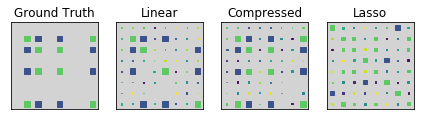

In [333]:
from matplotlib import pyplot as plt
from forest.benchmarking.plotting import hinton
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
hinton(rho_true, ax=ax1)
hinton(rho_linear, ax=ax2)
hinton(rho_compressed, ax=ax3)
hinton(rho_lasso, ax=ax4)
ax1.set_title('Ground Truth')
ax2.set_title('Linear')
ax3.set_title('Compressed')
ax4.set_title('Lasso')
fig.tight_layout()

## Calculate matrix norm between true and estimated rho

In [334]:
print("Linear norm:")
print(np.linalg.norm(rho_linear - rho_true))
print("Compressed norm:")
print(np.linalg.norm(rho_compressed - rho_true))
print("Lasso norm:")
print(np.linalg.norm(rho_lasso - rho_true))

Linear norm:
0.5041939111096045
Compressed norm:
0.09469354720259016
Lasso norm:
1.0904516061601754


## Plot graph of results for various measurement values

Analyzing performance of tomography algorithms on program:
H 0
H 1
H 2
CZ 0 2
RY(-pi/2) 0
X 2
CNOT 1 2

Running iteration for pauli number: 8
Running iteration for pauli number: 16
Running iteration for pauli number: 24
Running iteration for pauli number: 32
Running iteration for pauli number: 40
Running iteration for pauli number: 48
Running iteration for pauli number: 56


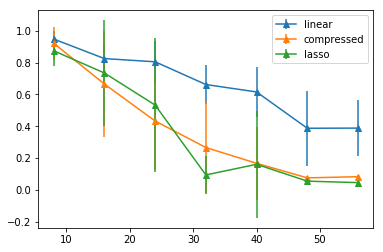

In [300]:
import matplotlib.pyplot as plt

#max_pauli_num = 4 ** len(qubits)
#max_pauli_num = 2
num_trials = 10

linear_norms = {}
linear_norms['vals'] = []
linear_norms['stds'] = []
compressed_norms = {}
compressed_norms['vals'] = []
compressed_norms['stds'] = []
lasso_norms = {}
lasso_norms['vals'] = []
lasso_norms['stds'] = []

print("Analyzing performance of tomography algorithms on program:")
print(program)

x = [i * 8 for i in range(1, 8)]

for i in x:
    print("Running iteration for pauli number: %d" % i)
    linear_vec = np.zeros((num_trials))
    compressed_vec = np.zeros((num_trials))
    lasso_vec = np.zeros((num_trials))
    for j in range(num_trials):
        rho_linear = debugger.tomographize("linear_inv", i, program, qubits)
        rho_compressed = debugger.tomographize("compressed", i, program, qubits)
        rho_lasso = debugger.tomographize("lasso", i, program, qubits)
        
        linear_vec[j] = np.linalg.norm(rho_linear - rho_true)
        compressed_vec[j] = np.linalg.norm(rho_compressed - rho_true)
        lasso_vec[j] = np.linalg.norm(rho_lasso - rho_true)
    
    linear_norms['vals'].append(np.mean(linear_vec))
    linear_norms['stds'].append(np.std(linear_vec))
    compressed_norms['vals'].append(np.mean(compressed_vec))
    compressed_norms['stds'].append(np.std(compressed_vec))
    lasso_norms['vals'].append(np.mean(lasso_vec))
    lasso_norms['stds'].append(np.std(lasso_vec))

plt.errorbar(x, linear_norms['vals'], linear_norms['stds'], marker='^', label='linear')
plt.errorbar(x, compressed_norms['vals'], compressed_norms['stds'], marker='^', label='compressed')
plt.errorbar(x, lasso_norms['vals'], lasso_norms['stds'], marker='^', label='lasso')
plt.legend()
plt.show()

## Now test with noise!

In [304]:
with open('noise_model.quil', 'r') as file:
    noise_model = file.read()

Recovered linear density matrix
Recovered compressed density matrix
Recovered lasso density matrix
[[ 0.125+0.j     0.001-0.125j  0.125+0.001j  0.   +0.125j  0.126+0.001j
   0.   +0.126j -0.125+0.j    -0.001+0.124j]
 [ 0.001+0.125j  0.124+0.j     0.   +0.125j -0.125+0.001j  0.   +0.126j
  -0.125+0.001j -0.001-0.124j -0.124-0.j   ]
 [ 0.125-0.001j  0.   -0.125j  0.126+0.j     0.001+0.125j  0.126-0.j
   0.001+0.126j -0.125+0.001j -0.   +0.124j]
 [ 0.   -0.125j -0.125-0.001j  0.001-0.125j  0.125+0.j     0.001-0.126j
   0.125+0.j    -0.   +0.124j  0.124+0.001j]
 [ 0.126-0.001j  0.   -0.126j  0.126+0.j     0.001+0.126j  0.127+0.j
   0.001+0.127j -0.125+0.001j -0.   +0.125j]
 [ 0.   -0.126j -0.125-0.001j  0.001-0.126j  0.125-0.j     0.001-0.127j
   0.126+0.j    -0.   +0.125j  0.125+0.001j]
 [-0.125-0.j    -0.001+0.124j -0.125-0.001j -0.   -0.124j -0.125-0.001j
  -0.   -0.125j  0.124+0.j     0.001-0.123j]
 [-0.001-0.124j -0.124+0.j    -0.   -0.124j  0.124-0.001j -0.   -0.125j
   0.125-0.001j 

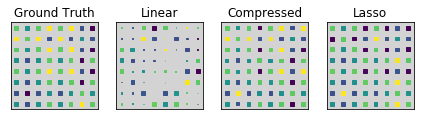

In [319]:
qubits = [0, 1, 2]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += Program("NOISY-CZ 0 2")
program += Program("NOISY-RX-PLUS-90 1")
program += Program("NOISY-RX-MINUS-90 2")
program += Program("NOISY-CZ 1 2")
program += X(qubits[2])
program += CNOT(qubits[1], qubits[2])

program = Program(noise_model) + program

m = 32

debugger = TomographyDebugger()
rho_linear = debugger.tomographize("linear_inv", m, program, qubits)
print("Recovered linear density matrix")

rho_compressed = debugger.tomographize("compressed", m, program, qubits)
print("Recovered compressed density matrix")

rho_lasso = debugger.tomographize("lasso", m, program, qubits)
print("Recovered lasso density matrix")

wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
hinton(rho_true, ax=ax1)
hinton(rho_linear, ax=ax2)
hinton(rho_compressed, ax=ax3)
hinton(rho_lasso, ax=ax4)
ax1.set_title('Ground Truth')
ax2.set_title('Linear')
ax3.set_title('Compressed')
ax4.set_title('Lasso')
fig.tight_layout()

print("Linear norm:")
print(np.linalg.norm(rho_linear - rho_true))
print("Compressed norm:")
print(np.linalg.norm(rho_compressed - rho_true))
print("Lasso norm:")
print(np.linalg.norm(rho_lasso - rho_true))

## Noiseless version

Recovered linear density matrix
Recovered compressed density matrix
Recovered lasso density matrix
[[ 0.125+0.j    -0.   -0.125j  0.125+0.j     0.   +0.125j  0.125+0.j
   0.   +0.125j -0.125-0.j     0.   +0.125j]
 [-0.   +0.125j  0.125+0.j    -0.   +0.125j -0.125+0.j    -0.   +0.125j
  -0.125+0.j     0.   -0.125j -0.125+0.j   ]
 [ 0.125+0.j    -0.   -0.125j  0.125+0.j     0.   +0.125j  0.125+0.j
   0.   +0.125j -0.125-0.j     0.   +0.125j]
 [ 0.   -0.125j -0.125+0.j     0.   -0.125j  0.125+0.j     0.   -0.125j
   0.125+0.j    -0.   +0.125j  0.125+0.j   ]
 [ 0.125+0.j    -0.   -0.125j  0.125+0.j     0.   +0.125j  0.125+0.j
   0.   +0.125j -0.125-0.j     0.   +0.125j]
 [ 0.   -0.125j -0.125+0.j     0.   -0.125j  0.125+0.j     0.   -0.125j
   0.125+0.j    -0.   +0.125j  0.125+0.j   ]
 [-0.125+0.j     0.   +0.125j -0.125+0.j    -0.   -0.125j -0.125+0.j
  -0.   -0.125j  0.125+0.j    -0.   -0.125j]
 [ 0.   -0.125j -0.125+0.j     0.   -0.125j  0.125+0.j     0.   -0.125j
   0.125+0.j    -0.   

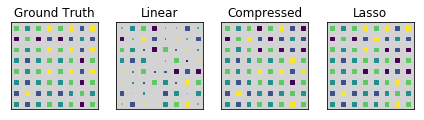

In [320]:
program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(0, 2)
program += RX(np.pi/2, 1)
program += RX(-np.pi/2, 2)
program += CZ(1, 2)
program += X(qubits[2])
program += CNOT(qubits[1], qubits[2])

m = 32

debugger = TomographyDebugger()
rho_linear = debugger.tomographize("linear_inv", m, program, qubits)
print("Recovered linear density matrix")

rho_compressed = debugger.tomographize("compressed", m, program, qubits)
print("Recovered compressed density matrix")

rho_lasso = debugger.tomographize("lasso", m, program, qubits)
print("Recovered lasso density matrix")

wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
hinton(rho_true, ax=ax1)
hinton(rho_linear, ax=ax2)
hinton(rho_compressed, ax=ax3)
hinton(rho_lasso, ax=ax4)
ax1.set_title('Ground Truth')
ax2.set_title('Linear')
ax3.set_title('Compressed')
ax4.set_title('Lasso')
fig.tight_layout()

print("Linear norm:")
print(np.linalg.norm(rho_linear - rho_true))
print("Compressed norm:")
print(np.linalg.norm(rho_compressed - rho_true))
print("Lasso norm:")
print(np.linalg.norm(rho_lasso - rho_true))

## Plot graph of results for noiseless program

Analyzing performance of tomography algorithms on program:
H 0
H 1
H 2
CZ 0 2
RX(pi/2) 1
RX(-pi/2) 2
CZ 1 2
X 2
CNOT 1 2

Running iteration for pauli number: 8
Running iteration for pauli number: 16
Running iteration for pauli number: 24
Running iteration for pauli number: 32


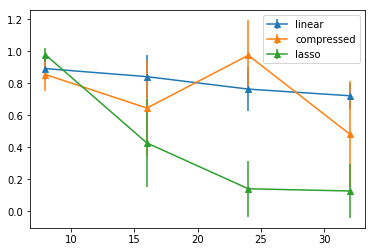

In [321]:
qubits = [0, 1, 2]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(0, 2)
program += RX(np.pi/2, 1)
program += RX(-np.pi/2, 2)
program += CZ(1, 2)
program += X(qubits[2])
program += CNOT(qubits[1], qubits[2])

debugger = TomographyDebugger()

num_trials = 5

linear_norms = {}
linear_norms['vals'] = []
linear_norms['stds'] = []
compressed_norms = {}
compressed_norms['vals'] = []
compressed_norms['stds'] = []
lasso_norms = {}
lasso_norms['vals'] = []
lasso_norms['stds'] = []

print("Analyzing performance of tomography algorithms on program:")
print(program)

x = [i * 8 for i in range(1, 5)]

for i in x:
    print("Running iteration for pauli number: %d" % i)
    linear_vec = np.zeros((num_trials))
    compressed_vec = np.zeros((num_trials))
    lasso_vec = np.zeros((num_trials))
    for j in range(num_trials):
        rho_linear = debugger.tomographize("linear_inv", i, program, qubits)
        rho_compressed = debugger.tomographize("compressed", i, program, qubits)
        rho_lasso = debugger.tomographize("lasso", i, program, qubits)
        
        linear_vec[j] = np.linalg.norm(rho_linear - rho_true)
        compressed_vec[j] = np.linalg.norm(rho_compressed - rho_true)
        lasso_vec[j] = np.linalg.norm(rho_lasso - rho_true)
    
    linear_norms['vals'].append(np.mean(linear_vec))
    linear_norms['stds'].append(np.std(linear_vec))
    compressed_norms['vals'].append(np.mean(compressed_vec))
    compressed_norms['stds'].append(np.std(compressed_vec))
    lasso_norms['vals'].append(np.mean(lasso_vec))
    lasso_norms['stds'].append(np.std(lasso_vec))

plt.errorbar(x, linear_norms['vals'], linear_norms['stds'], marker='^', label='linear')
plt.errorbar(x, compressed_norms['vals'], compressed_norms['stds'], marker='^', label='compressed')
plt.errorbar(x, lasso_norms['vals'], lasso_norms['stds'], marker='^', label='lasso')
plt.legend()
plt.show()

## Plot results for noisy program

Analyzing performance of tomography algorithms on program:
H 0
H 1
H 2
NOISY-CZ 0 2
NOISY-RX-PLUS-90 1
NOISY-RX-MINUS-90 2
NOISY-CZ 1 2
X 2
CNOT 1 2

Running iteration for pauli number: 8
Running iteration for pauli number: 16
Running iteration for pauli number: 24
Running iteration for pauli number: 32


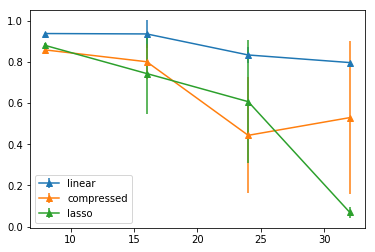

In [325]:
qubits = [0, 1, 2]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += Program("NOISY-CZ 0 2")
program += Program("NOISY-RX-PLUS-90 1")
program += Program("NOISY-RX-MINUS-90 2")
program += Program("NOISY-CZ 1 2")
program += X(qubits[2])
program += CNOT(qubits[1], qubits[2])

short_program = program #Useful for printing out the current program without too many noisy gates
program = Program(noise_model) + program

debugger = TomographyDebugger()

#Noisy program takes longer to run so reduce num_trials
num_trials = 2

linear_norms = {}
linear_norms['vals'] = []
linear_norms['stds'] = []
compressed_norms = {}
compressed_norms['vals'] = []
compressed_norms['stds'] = []
lasso_norms = {}
lasso_norms['vals'] = []
lasso_norms['stds'] = []

print("Analyzing performance of tomography algorithms on program:")
print(short_program)

x = [i * 8 for i in range(1, 5)]

for i in x:
    print("Running iteration for pauli number: %d" % i)
    linear_vec = np.zeros((num_trials))
    compressed_vec = np.zeros((num_trials))
    lasso_vec = np.zeros((num_trials))
    for j in range(num_trials):
        rho_linear = debugger.tomographize("linear_inv", i, program, qubits)
        rho_compressed = debugger.tomographize("compressed", i, program, qubits)
        rho_lasso = debugger.tomographize("lasso", i, program, qubits)
        
        linear_vec[j] = np.linalg.norm(rho_linear - rho_true)
        compressed_vec[j] = np.linalg.norm(rho_compressed - rho_true)
        lasso_vec[j] = np.linalg.norm(rho_lasso - rho_true)
    
    linear_norms['vals'].append(np.mean(linear_vec))
    linear_norms['stds'].append(np.std(linear_vec))
    compressed_norms['vals'].append(np.mean(compressed_vec))
    compressed_norms['stds'].append(np.std(compressed_vec))
    lasso_norms['vals'].append(np.mean(lasso_vec))
    lasso_norms['stds'].append(np.std(lasso_vec))

plt.errorbar(x, linear_norms['vals'], linear_norms['stds'], marker='^', label='linear')
plt.errorbar(x, compressed_norms['vals'], compressed_norms['stds'], marker='^', label='compressed')
plt.errorbar(x, lasso_norms['vals'], lasso_norms['stds'], marker='^', label='lasso')
plt.legend()
plt.show()